In [44]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Loading and preprocessing Image Dataset

In [45]:

import torch.utils.data.dataloader
# resizing image to 224x224 and converting to tensors
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Fix applied here
])
# Loading dataset
train_dt = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_ld = torch.utils.data.DataLoader(train_dt, batch_size = 32, shuffle = True)

test_dt = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_ld = torch.utils.data.DataLoader(test_dt, batch_size = 32, shuffle = False)

class_names = train_dt.classes

print("Data Loaded Successfully")

Data Loaded Successfully


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.9137255].


torch.Size([3, 224, 224]) tensor(1)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

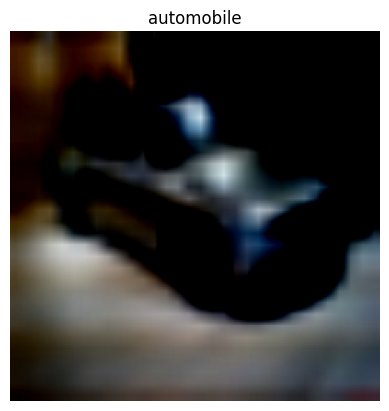

In [46]:

image_batch, label_batch = next(iter(train_ld))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

Patch Embedding Layer

In [48]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_channels = 3, embed_dim = 768):
        super().__init__()
        self.num_patches = (img_size // patch_size) **2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride= patch_size)

    def forward (self, x):
        x= self.projection(x)
        x = x.flatten(2).transpose(1, 2)  # Fix 2: Correct patch flattening
        return x


Adding Class Token & Positional Encoding

In [50]:
class ViTEmbedding(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, in_channels = 3, embed_dim = 768):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size,patch_size,in_channels,embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x= self.patch_embed(x)
        cls_tokens = self.cls_token.repeat(B, 1, 1)  # Fix 3: Avoid shared tensor expansion issue
        x= torch.cat((cls_tokens, x), dim=1)
        x= x+self.pos_embedding
        return x
   


Multi-Head Self-Attention (MHSA)

In [51]:
class MHSA(nn.Module):
    def __init__(self, embed_dim = 768, num_heads = 12, attn_dropout = 0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim= embed_dim, num_heads = num_heads, dropout= attn_dropout,batch_first=True)

    def forward(self,x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x, key = x, value = x, need_weights = False)
        return attn_output

MLP Block

In [53]:
class MLP(nn.Module):
    def __init__(self, embed_dim = 768, mlp_size = 3072, dropout = 0.2):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embed_dim)
        self.mlp = nn.Sequential(nn.Linear(in_features=embed_dim, out_features= mlp_size), nn.GELU(), nn.Dropout(p=dropout), 
                                 nn.Linear(in_features=mlp_size, out_features=embed_dim),nn.Dropout(p=dropout))
        

    def forward(self, x):
        x= self.layer_norm(x)
        x= self.mlp(x)
        return x


Creating a Transformer Encoder by Combining custom made layer

In [55]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_size=3072, attn_dropout=0, mlp_dropout=0.2):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MHSA(embed_dim, num_heads, attn_dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_size, mlp_dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))  # Fix 4: Proper LayerNorm before residual connection
        x = x + self.mlp(self.norm2(x))
        return x

In [56]:
transfomer_encoder_block = TransformerEncoder()
from torchinfo import summary

summary(model=transfomer_encoder_block, input_size=(1, 197, 768), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings= ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MHSA (attn)                                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MLP (mlp)                                        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)              

Building a Vision Transformer

In [57]:
class ViT(nn.Module):
    def __init__(self, img_size=224, num_classes=10, patch_size=16, in_channels=3, embed_dim=768, num_layers=12):
        super().__init__()
        self.embedding = ViTEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.encoder = nn.Sequential(*[TransformerEncoder(embed_dim) for _ in range(num_layers)])
        self.classifier = nn.Linear(embed_dim, num_classes)  # Fix 5: Added classification head

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)[:, 0]  # Taking CLS token
        return self.classifier(x)


Training Model

In [58]:
import torch 
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Fix 6: Adjusted learning rate

for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_ld:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_ld)}, Accuracy: {100 * correct / total:.2f}%")


Epoch 1, Loss: 1.8350099039169283, Accuracy: 35.09%
Epoch 2, Loss: 1.4143553242344773, Accuracy: 48.75%
Epoch 3, Loss: 1.26040218708535, Accuracy: 54.35%
Epoch 4, Loss: 1.1545519717061512, Accuracy: 58.24%
Epoch 5, Loss: 1.0714902634507788, Accuracy: 61.38%
Epoch 6, Loss: 0.9997313369830602, Accuracy: 64.05%
Epoch 7, Loss: 0.9361547530841461, Accuracy: 66.53%
Epoch 8, Loss: 0.8656078258425627, Accuracy: 68.92%
Epoch 9, Loss: 0.7986490803121834, Accuracy: 71.16%
Epoch 10, Loss: 0.7141210266358564, Accuracy: 74.13%
Epoch 11, Loss: 0.6364977036674894, Accuracy: 76.96%
Epoch 12, Loss: 0.5433645372351087, Accuracy: 80.44%
Epoch 13, Loss: 0.45000905276622366, Accuracy: 83.79%
Epoch 14, Loss: 0.3603842271657533, Accuracy: 87.11%
Epoch 15, Loss: 0.29520393553132135, Accuracy: 89.28%
Epoch 16, Loss: 0.24528285813108516, Accuracy: 91.31%
Epoch 17, Loss: 0.2073920546737109, Accuracy: 92.59%
Epoch 18, Loss: 0.18475407619781253, Accuracy: 93.43%
Epoch 19, Loss: 0.17890984965732615, Accuracy: 93.63%

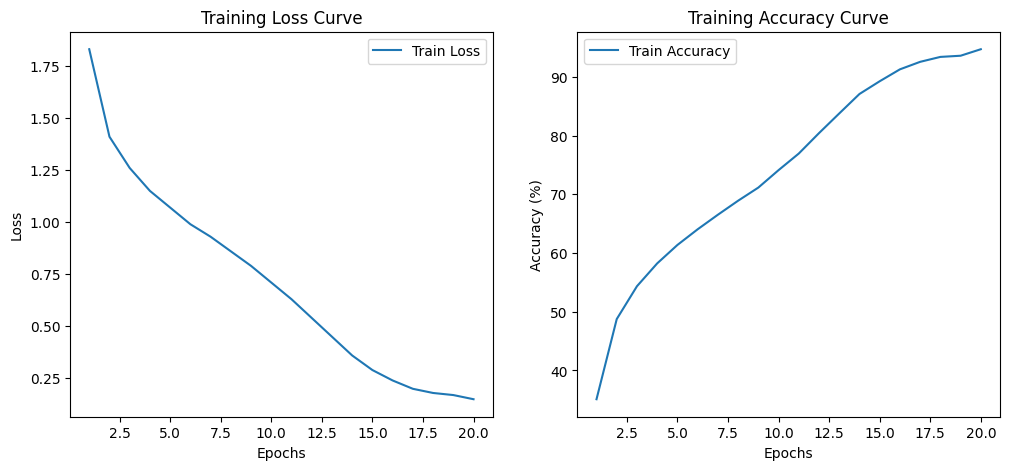

In [ ]:
import matplotlib.pyplot as plt


epochs = list(range(1, 21))  
train_losses = [1.83, 1.41, 1.26, 1.15, 1.07, 0.99, 0.93, 0.86, 0.79, 0.71, 0.63, 0.54, 0.45, 0.36, 0.29, 0.24, 0.20, 0.18, 0.17, 0.15]
train_accuracies = [35.09, 48.75, 54.35, 58.24, 61.38, 64.05, 66.53, 68.92, 71.16, 74.13, 76.96, 80.44, 83.79, 87.11, 89.28, 91.31, 92.59, 93.43, 93.63, 94.74]

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, linestyle="-", label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, linestyle="-", label="Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.legend()

plt.show()





Training the same Dataset with pre-trained model

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt


In [63]:
# Data Transformations: Normalization and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT requires 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Pre-trained model normalization
])

# Load the CIFAR-10 training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = 10


In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load Pretrained ViT-B/16
pretrained_vit = models.vit_b_16(pretrained=True)

# Modify the classifier head for CIFAR-10 
pretrained_vit.heads.head = nn.Linear(768, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_vit = pretrained_vit.to(device)


/home/sameer-malik/Torch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameer-malik/Torch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
from torchinfo import summary

summary(model = pretrained_vit, input_size=(32,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings= ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_vit.parameters(), lr=1e-4)

train_losses, train_accuracies = [], []

for epoch in range(20):  
    pretrained_vit.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_ld:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained_vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_ld)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch 1, Loss: 0.2398, Accuracy: 92.06%
Epoch 2, Loss: 0.1263, Accuracy: 95.76%
Epoch 3, Loss: 0.0956, Accuracy: 96.81%
Epoch 4, Loss: 0.0804, Accuracy: 97.28%
Epoch 5, Loss: 0.0658, Accuracy: 97.80%
Epoch 6, Loss: 0.0570, Accuracy: 97.99%
Epoch 7, Loss: 0.0516, Accuracy: 98.25%
Epoch 8, Loss: 0.0463, Accuracy: 98.43%
Epoch 9, Loss: 0.0445, Accuracy: 98.47%
Epoch 10, Loss: 0.0366, Accuracy: 98.78%
Epoch 11, Loss: 0.0392, Accuracy: 98.66%
Epoch 12, Loss: 0.0353, Accuracy: 98.73%
Epoch 13, Loss: 0.0326, Accuracy: 98.92%
Epoch 14, Loss: 0.0338, Accuracy: 98.86%
Epoch 15, Loss: 0.0272, Accuracy: 99.09%
Epoch 16, Loss: 0.0299, Accuracy: 99.02%
Epoch 17, Loss: 0.0269, Accuracy: 99.10%
Epoch 18, Loss: 0.0240, Accuracy: 99.21%
Epoch 19, Loss: 0.0268, Accuracy: 99.05%
Epoch 20, Loss: 0.0226, Accuracy: 99.25%


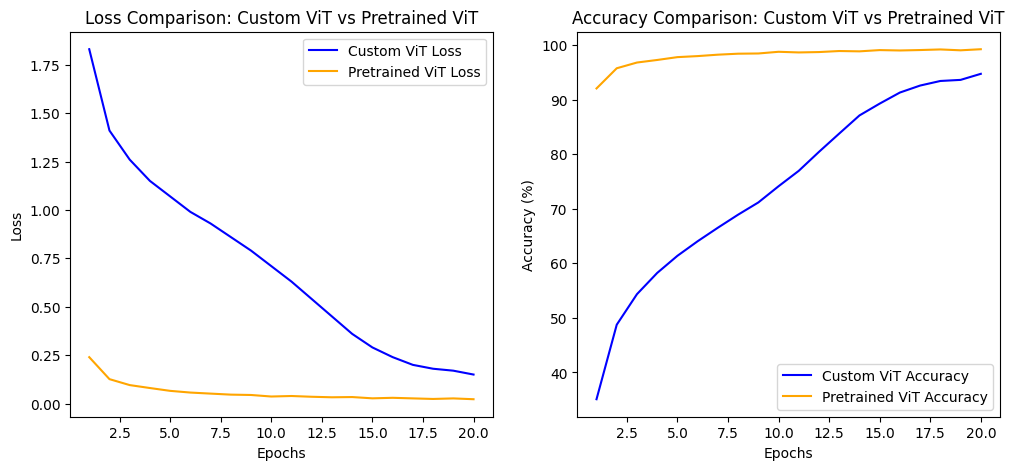

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 21))


custom_vit_loss = [1.83, 1.41, 1.26, 1.15, 1.07, 0.99, 0.93, 0.86, 0.79, 0.71, 0.63, 0.54, 0.45, 0.36, 0.29, 0.24, 0.20, 0.18, 0.17, 0.15]
custom_vit_acc = [35.09, 48.75, 54.35, 58.24, 61.38, 64.05, 66.53, 68.92, 71.16, 74.13, 76.96, 80.44, 83.79, 87.11, 89.28, 91.31, 92.59, 93.43, 93.63, 94.74]

pretrained_vit_loss = [0.2398, 0.1263, 0.0956, 0.0804, 0.0658, 0.0570, 0.0516, 0.0463, 0.0445, 0.0366, 0.0392, 0.0353, 0.0326, 0.0338, 0.0272, 0.0299, 0.0269, 0.0240, 0.0268, 0.0226]

pretrained_vit_acc = [92.06, 95.76, 96.81, 97.28, 97.80, 97.99, 98.25, 98.43, 98.47, 98.78, 98.66, 98.73, 98.92, 98.86, 99.09, 99.02, 99.10, 99.21, 99.05, 99.25]


plt.figure(figsize=(12, 5))

# Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs, custom_vit_loss, linestyle="-", color="blue", label="Custom ViT Loss")
plt.plot(epochs, pretrained_vit_loss, linestyle="-", color="orange", label="Pretrained ViT Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison: Custom ViT vs Pretrained ViT")
plt.legend()

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, custom_vit_acc, linestyle="-", color="blue", label="Custom ViT Accuracy")
plt.plot(epochs, pretrained_vit_acc, linestyle="-", color="orange", label="Pretrained ViT Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison: Custom ViT vs Pretrained ViT")
plt.legend()

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.8666667].


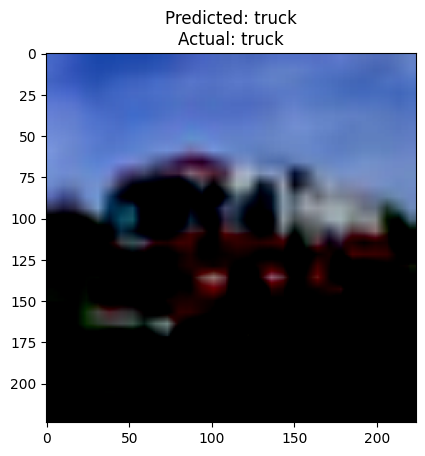

Correct Prediction ✅


In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Get class names
class_names = test_dataset.classes

# Select a random image
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

# Convert image to batch format
image = image.unsqueeze(0).to(device)  # Add batch dimension

# Predict using model
model.eval()
with torch.no_grad():
    output = model(image)
    predicted_class = torch.argmax(output, dim=1).item()

# Display image and prediction
plt.imshow(image.cpu().squeeze().permute(1, 2, 0))  # Convert tensor to image
plt.title(f"Predicted: {class_names[predicted_class]}\nActual: {class_names[label]}")
plt.show()

# Check accuracy for this image
if predicted_class == label:
    print("Correct Prediction ")
else:
    print("Incorrect Prediction ")


Fine Tuning Custom ViT with LoRA

In [103]:
import torch
import torch.nn as nn
from peft import LoraConfig, get_peft_model, TaskType

class MHSA(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, attn_dropout=0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.layer_norm = nn.LayerNorm(embed_dim)

        # Define explicit Q, K, V projection layers
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.out_proj = nn.Linear(embed_dim, embed_dim)  # Output projection

    def forward(self, x):
        x = self.layer_norm(x)

        # Compute Q, K, V
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)

        # Compute Attention Scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_probs = self.attn_dropout(attn_probs)

        # Apply attention weights
        attn_output = torch.matmul(attn_probs, V)
        attn_output = self.out_proj(attn_output)

        return attn_output

# Load your ViT model
model = ViT().to("cuda")

# Apply LoRA to `multihead_attn.in_proj_weight`
lora_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=8,  # Rank of LoRA matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,
    target_modules=["q_proj","k_proj", "v_proj", "out_proj"]  # Apply LoRA to self-attention weights
)

# Convert to LoRA model
model = get_peft_model(model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()


trainable params: 589,824 || all params: 86,403,850 || trainable%: 0.6826


In [101]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10  # Reduce epochs since LoRA fine-tunes faster

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_ld:
        images, labels = images.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_ld)}, Accuracy: {100 * correct / total:.2f}%")


TypeError: ViT.forward() got an unexpected keyword argument 'input_ids'